In [1]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


In [2]:
base_dir = r".\Dataset_25000x5"
csv_path = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 32
SEED = 42

In [3]:
dataset_name   = os.path.basename(base_dir)
prefix_pattern = rf'^{re.escape(dataset_name)}\./'

df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False)
df['filepath'] = df['filepath'].str.replace(prefix_pattern, '', regex=True)

In [4]:
df

,filepath,label
0,original/000000000025.jpg,Original
1,salt_pepper/000000000025.jpg,Salt & Pepper
2,gaussian/000000000025.jpg,Gaussian
3,uniform/000000000025.jpg,Uniform
4,erlang/000000000025.jpg,Erlang
...,...,...
124995,original/000000581929.jpg,Original
124996,salt_pepper/000000581929.jpg,Salt & Pepper
124997,gaussian/000000581929.jpg,Gaussian
124998,uniform/000000581929.jpg,Uniform


In [5]:
# Split stratificati (stessi esempi per classe)

# 70-15-15 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 70.0%  |  Val: 15.0%  |  Test: 15.0%


In [6]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 87500 validated image filenames belonging to 5 classes.
Found 18750 validated image filenames belonging to 5 classes.
Found 18750 validated image filenames belonging to 5 classes.


{'Erlang': 0, 'Gaussian': 1, 'Original': 2, 'Salt & Pepper': 3, 'Uniform': 4}

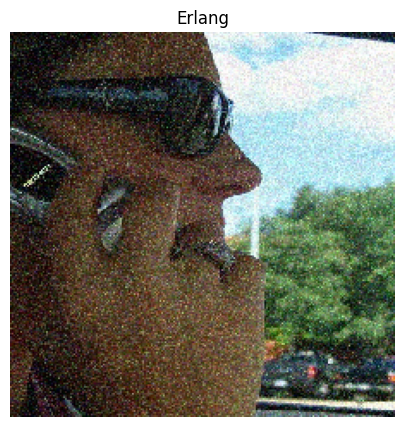

In [7]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [8]:
model = models.Sequential()
model.add(layers.Input(shape=(IMG_H, IMG_W, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

In [15]:
# Imposto batch_size per ridurre overhead cpu-gpu (cpu è il bottleneck)
BATCH = 32
train_gen.batch_size = BATCH
val_gen.batch_size   = BATCH
test_gen.batch_size  = BATCH

steps_per_epoch    = train_gen.samples // BATCH
validation_steps  = val_gen.samples // BATCH

In [16]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [23]:
best_model = load_model('final_model.h5')

In [18]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [19]:
# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch, # numero batch in una epoch di training
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[es, mc], # Early Stopping + best model checkpoint
    workers=4, # numero thread in parallelo
    use_multiprocessing=False, # non si può
    max_queue_size=10
)

Epoch 1/50
2734/2734 [==============================] - 311s 113ms/step - loss: 0.8029 - accuracy: 0.6005 - val_loss: 0.6474 - val_accuracy: 0.6764
Epoch 2/50
  98/2734 [>.............................] - ETA: 3:55 - loss: 0.6796 - accuracy: 0.6594

KeyboardInterrupt: 

In [13]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")


✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [22]:
model.save('final_model.h5')

In [24]:
test_loss, test_acc = model.evaluate(test_gen) # CAZZO (45% accuracy)

3/3 [==============================] - 1s 19ms/step - loss: 1.1572 - accuracy: 0.4133


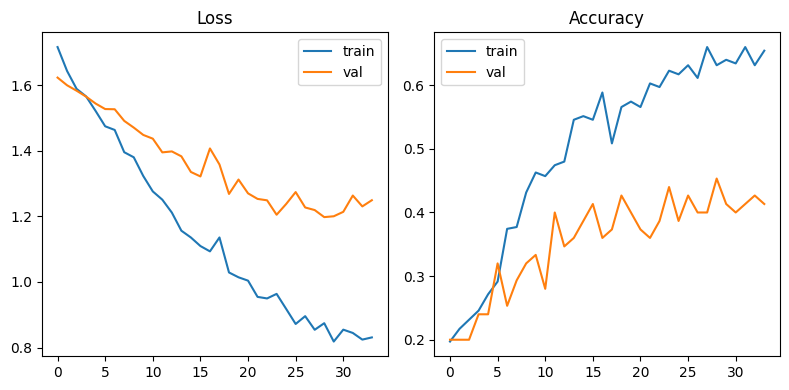

In [25]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizzazione delle immagini (da 0-255 a 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(28,28)))    # flattens the 28x28 images into arrays of 784 pixels
model.add(Dense(128, activation='relu'))   # 1st hidden layer
model.add(Dense(128, activation='relu'))   # 2nd hidden layer
model.add(Dense(10, activation='softmax')) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\tomma\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.fit(x_train, y_train, epochs=4) #99.79%, 0.0070 loss

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8823 - loss: 0.4054
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9700 - loss: 0.0983
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9783 - loss: 0.0677
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9850 - loss: 0.0484


In [53]:
predictions = model.predict(x_test)
y_pred = [np.argmax(prediction) for prediction in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
